# Latent Semantic Analysis (LSA)

This notebook is for developing, not implementing a solution.

*Current State*
- Preprocessing was performed for a Bag-of-upto-Ngrams with TF-IDF representation
- This type of representation still suffers from the curse of dimensionality, best accuracies achieved with a Bag-of-upto-Trigram TF-IDF training subset of 120k documents (Tweets) and 100k terms, using a baseline Logistic Regression model, were approx. 80%
- LSA, in particular, matrix decomposition using SVD, can be used to reduce a document-term matrix to an approximate document-component (or topic) matrix that captures more signal per component, if not overall

*Results*
- With 10% of our training data, properly transformed as described above, and evaluated with the same baseline LR model, the projection into a latent semantic space of 300 components seems to have reduced the overall signal, achieving only 75% accuracy (1,000 components bump it up to 77%)
- It remains to be seen whether with addition of feature engineering, this reduced semantic space will perform better than adding those engineered features into the much larger sparse matrix (which yielded no improvement)
- It also remains to be seen whether more complex models like Random Forests will perform better in this reduced semantic space
- Lastly, perhaps by plotting learning curves we'll see whether SVD helps given more data
---

In [1]:
import os
import time

import numpy as np
import pandas as pd

import cleanup_module as Cmod

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

### Sample 10% of the training data for POC

In [2]:
# load minimally prepared X, y train subsets
raw_path = os.path.join("..","data","1_raw","sentiment140")
X_train = pd.read_csv(os.path.join(raw_path, "X_train.csv"))
y_train = pd.read_csv(os.path.join(raw_path, "y_train.csv"))

# sample for dev
X, X_rest, y, y_rest = train_test_split(X_train, y_train, test_size=0.9, random_state=42)

# create array
X_array = np.array(X.iloc[:, 2]).ravel()
y_array = y.iloc[:,0].ravel()

In [3]:
X_array.shape, y_array.shape

((119747,), (119747,))

### Preprocess Bag-of-upto-Trigrams with 100,000 terms

Using `sublinear_tf=True, use_idf=True` as recommended in [docs](https://scikit-learn.org/stable/modules/decomposition.html#lsa): 

*In particular, sublinear scaling and inverse document frequency should be turned on (`sublinear_tf=True, use_idf=True`) to bring the feature values closer to a Gaussian distribution, compensating for LSA’s erroneous assumptions about textual data.*

In [4]:
pipe = Pipeline([('counter', Cmod.DocumentToNgramCounterTransformer(n_grams=3)),
                 ('bow', Cmod.WordCounterToVectorTransformer(vocabulary_size=100000)),
                 ('tfidf', TfidfTransformer(sublinear_tf=True, use_idf=True))]) # performs similar to default (False)

In [5]:
start_time = time.time()

X_train_transformed = pipe.fit_transform(X_array)

mins, secs = divmod(time.time() - start_time, 60)
print(f'Elapsed: {mins:0.0f} min {secs:0.0f} sec')

Elapsed: 2 min 41 sec


In [6]:
X_train_transformed # document term matrix

<119747x100001 sparse matrix of type '<class 'numpy.float64'>'
	with 2687589 stored elements in Compressed Sparse Row format>

### SVD

Point of departure: [Analytics Vidhya Tutorial](https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/). 

Consulted Prof. Steve Brunton's [YouTube lecture series](https://www.youtube.com/playlist?list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv) and [Data-Driven Science and Engineering book](https://www.amazon.com/Data-Driven-Science-Engineering-Learning-Dynamical/dp/1108422098) - see notes from first few lectures [here](Extra_SteveBrunton_SVD_lecture.pdf).


Borroming from sklearn's **TruncatedSVD** class, "arpack" algorithm (the "randomized" algorithm takes longer and arrives at the same result), here are the relevant code bits:

[(source)](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/decomposition/_truncated_svd.py#L24)
```
149    def fit_transform(self, X, y=None):
[...]
168        if self.algorithm == "arpack":
169             U, Sigma, VT = svds(X, k=self.n_components, tol=self.tol)
170             # svds doesn't abide by scipy.linalg.svd/randomized_svd
171             # conventions, so reverse its outputs.
172            Sigma = Sigma[::-1]
173            U, VT = svd_flip(U[:, ::-1], VT[::-1])
```                                          

In [7]:
start_time = time.time()
U, Sigma, VT = svds(X_train_transformed.T, # transposed to a term-document matrix
                    k=1000) # k = number of components / "topics"
    
# reverse outputs
Sigma = Sigma[::-1]
U, VT = svd_flip(U[:, ::-1], VT[::-1])

mins, secs = divmod(time.time() - start_time, 60)
print(f'Elapsed: {mins:0.0f} min {secs:0.0f} sec')

Elapsed: 2 min 0 sec


In [8]:
U.shape, Sigma.shape, VT.shape

((100001, 300), (300,), (300, 119747))

In [9]:
V = VT.T
V.shape, y_array.shape

((119747, 300), (119747,))

- U contains the eigenvectors of the term correlations: $XX^T$
- V contains the eigenvectors of the document correlations: $X^TX$
- $\Sigma$ contains the singular values of the factorization

In [10]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, V, y_array, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.3s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished


accuracy: 0.7520 (+/- 0.0017)


In [11]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_array, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.3s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


accuracy: 0.8013 (+/- 0.0015)


In [12]:
import sys

sys.getsizeof(X_train_transformed), sys.getsizeof(V)

(56, 112)

In [13]:
from scipy.sparse import csr_matrix

V_sparse = csr_matrix(V, shape=(V.shape))

In [14]:
sys.getsizeof(V_sparse)

56

In [15]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, V_sparse, y_array, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.2s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


accuracy: 0.7520 (+/- 0.0017)


### Plotting singular values

The idea is to help see whether the full 1000 components are needed or we can get away with using a smaller subset - the results below show that despite a slightly faster training time (compared to the full 1000 components not the original data), the hit in accuracy isn't worth dumping those components that have "low energy" or seem to explain less of the variance in the data.

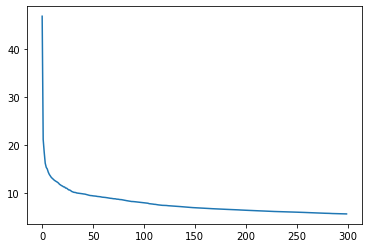

In [16]:
import matplotlib.pyplot as plt

plt.plot(Sigma)
plt.show()

---

Note: avoid Naive Bayes on SVD since it implies strong independence between variables.

Quoting the [Analytics Vidhya Tutorial](https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/) ~

"*Apart from LSA, there are other advanced and efficient topic modeling techniques such as Latent Dirichlet Allocation (LDA) and lda2Vec. We have a wonderful article on LDA which you can check out [here](https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/). lda2vec is a much more advanced topic modeling which is based on word2vec word embeddings.*"